In [4]:
import pandas as pd
import numpy as np
import requests
import xml.etree.ElementTree as ET
import yfinance as yf


In [5]:
import sys
!"{sys.executable}" -m pip install matplotlib



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Divya Sharma\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [6]:
import matplotlib.pyplot as plt

%matplotlib inline


In [10]:
rss_feeds = {
    "Yahoo Finance": "https://finance.yahoo.com/rss/topstories",
    "CNBC": "https://www.cnbc.com/id/10001147/device/rss/rss.html",
    "MarketWatch": "https://feeds.marketwatch.com/marketwatch/topstories"
}


In [24]:
# adding a user agent so that the RSS sites allow the request
req_headers = {
    "User-Agent": "Mozilla/5.0"
}

articles = []

for src in rss_feeds:
    link = rss_feeds[src]
    
    r = requests.get(link, headers=req_headers)

    if r.status_code != 200:
        print("Could not fetch data from", src)
        continue

    xml_data = r.content
    root = ET.fromstring(xml_data)

    for news_item in root.findall(".//item"):
        title = news_item.find("title")
        date = news_item.find("pubDate")

        if title is not None and date is not None:
            articles.append({
                "source": src,
                "headline": title.text,
                "pubDate": date.text
            })

print("Total news articles collected:", len(articles))



Total news articles collected: 82


In [25]:
raw_news_df = pd.DataFrame(articles)
raw_news_df.to_csv("news_raw.csv", index=False)
raw_news_df.head()

,source,headline,pubDate
0,Yahoo Finance,PNC completes $4.1bn purchase of FirstBank,2026-01-06T11:52:42Z
1,Yahoo Finance,"Stock market today: Dow, S&P 500, Nasdaq futur...",2026-01-05T23:52:17Z
2,Yahoo Finance,Top executives at subprime auto lender charged...,2026-01-06T11:45:00Z
3,Yahoo Finance,Morning Bid: Swiftly moving on,2026-01-06T11:06:08Z
4,Yahoo Finance,"HELOC and home equity loan rates today, Januar...",2026-01-06T11:00:41Z


## XML Structure Understanding

**XML tags used:**  
While parsing the RSS feed, I mainly used the `<item>`, `<title>`, and `<pubDate>` tags.

**Role of `<item>` tag:**  
Each `<item>` tag represents one individual news article in the RSS feed. It usually contains information such as the headline and the publication date.

**Difference between RSS and HTML:**  
RSS feeds are written in XML and are structured in a way that makes them easy for programs to read and extract data. HTML pages, on the other hand, are mainly designed for humans to view content visually in a web browser.


In [26]:
clean_news_df = raw_news_df.copy()

clean_news_df["pubDate"] = pd.to_datetime(
    clean_news_df["pubDate"], errors="coerce", utc=True
)

clean_news_df["date"] = clean_news_df["pubDate"].dt.date

clean_news_df["headline_length"] = clean_news_df["headline"].apply(len)

clean_news_df.to_csv("news_cleaned.csv", index=False)

clean_news_df.head()



,source,headline,pubDate,date,headline_length
0,Yahoo Finance,PNC completes $4.1bn purchase of FirstBank,2026-01-06 11:52:42+00:00,2026-01-06,42
1,Yahoo Finance,"Stock market today: Dow, S&P 500, Nasdaq futur...",2026-01-05 23:52:17+00:00,2026-01-05,89
2,Yahoo Finance,Top executives at subprime auto lender charged...,2026-01-06 11:45:00+00:00,2026-01-06,120
3,Yahoo Finance,Morning Bid: Swiftly moving on,2026-01-06 11:06:08+00:00,2026-01-06,31
4,Yahoo Finance,"HELOC and home equity loan rates today, Januar...",2026-01-06 11:00:41+00:00,2026-01-06,74


In [27]:
ticker = "AAPL"

stock_data = yf.download(
    ticker,
    period="1mo",
    interval="1d"
)
stock_data = stock_data[["Open", "High", "Low", "Close", "Volume"]]

stock_data.reset_index(inplace=True)
stock_data["date"] = stock_data["Date"].dt.date
stock_data.to_csv("stock_data.csv", index=False)
stock_data.head()


[*********************100%***********************]  1 of 1 completed


Price,Date,Open,High,Low,Close,Volume,date
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,
0,2025-12-08,278.130005,279.670013,276.149994,277.890015,38211800,2025-12-08
1,2025-12-09,278.160004,280.029999,276.920013,277.179993,32193300,2025-12-09
2,2025-12-10,277.750000,279.750000,276.440002,278.779999,33038300,2025-12-10
3,2025-12-11,279.100006,279.589996,273.809998,278.029999,33248000,2025-12-11
4,2025-12-12,277.899994,279.220001,276.820007,278.279999,39532900,2025-12-12


### Market Calendar Awareness

- Non-trading days include weekends and US market holidays.
- Stock markets do not trade due to regulatory holidays and weekends.
- News articles can still be published on non-trading days.


In [28]:
non_trading_news = clean_news_df[
    ~clean_news_df["date"].isin(stock_data["date"])
]

len(non_trading_news)


70

In [29]:
stock_data.columns = stock_data.columns.get_level_values(0)


In [30]:
stock_data["date"] = pd.to_datetime(stock_data["Date"]).dt.date


In [32]:
merged_df = clean_news_df.merge(
    stock,
    on="date",
    how="left"
)

merged_df["is_trading_day"] = ~merged_df["Open"].notna()

merged_df.to_csv("merged_midterm_data.csv", index=False)
merged_df.head()


,source,headline,pubDate,date,headline_length,Date,Open,High,Low,Close,Volume,is_trading_day
0,Yahoo Finance,PNC completes $4.1bn purchase of FirstBank,2026-01-06 11:52:42+00:00,2026-01-06,42,NaT,NaN,NaN,NaN,NaN,NaN,True
1,Yahoo Finance,"Stock market today: Dow, S&P 500, Nasdaq futur...",2026-01-05 23:52:17+00:00,2026-01-05,89,2026-01-05,270.640015,271.51001,266.140015,267.26001,45598200.0,False
2,Yahoo Finance,Top executives at subprime auto lender charged...,2026-01-06 11:45:00+00:00,2026-01-06,120,NaT,NaN,NaN,NaN,NaN,NaN,True
3,Yahoo Finance,Morning Bid: Swiftly moving on,2026-01-06 11:06:08+00:00,2026-01-06,31,NaT,NaN,NaN,NaN,NaN,NaN,True
4,Yahoo Finance,"HELOC and home equity loan rates today, Januar...",2026-01-06 11:00:41+00:00,2026-01-06,74,NaT,NaN,NaN,NaN,NaN,NaN,True


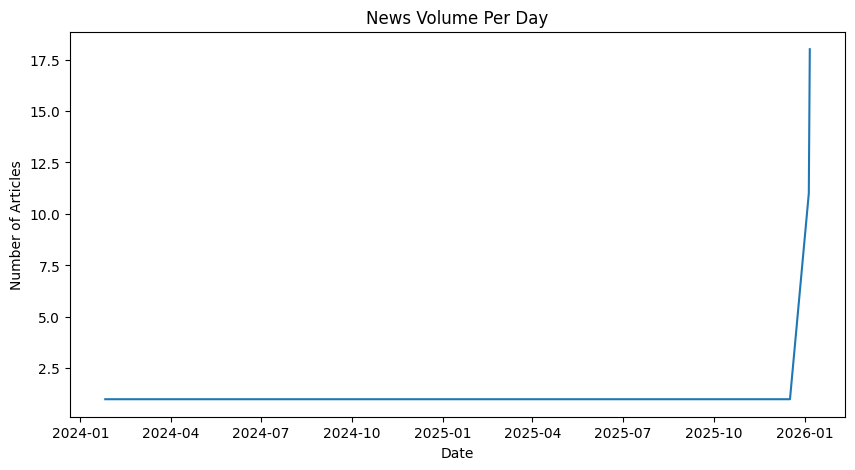

In [21]:
daily_news_count = merged_df.groupby("date").size()

daily_news_count.plot(kind="line", figsize=(10,5))
plt.title("Number of News Articles Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.show()


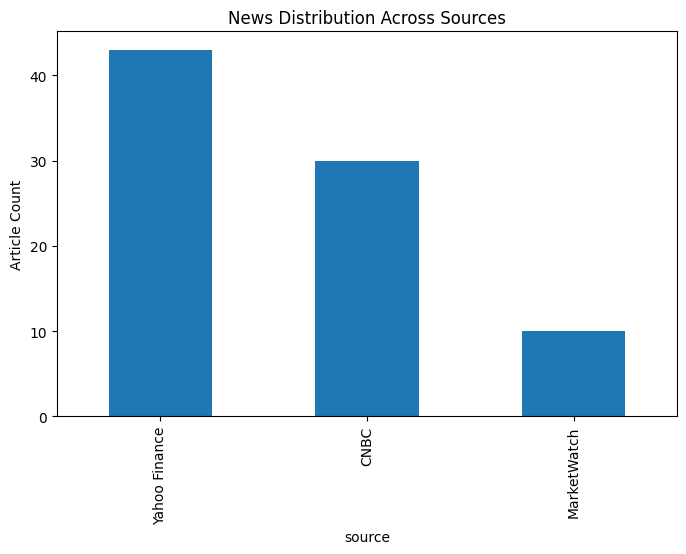

In [22]:
merged["source"].value_counts().plot(kind="bar", figsize=(8,5))
plt.title("News Distribution Across Sources")
plt.ylabel("Article Count")
plt.show()


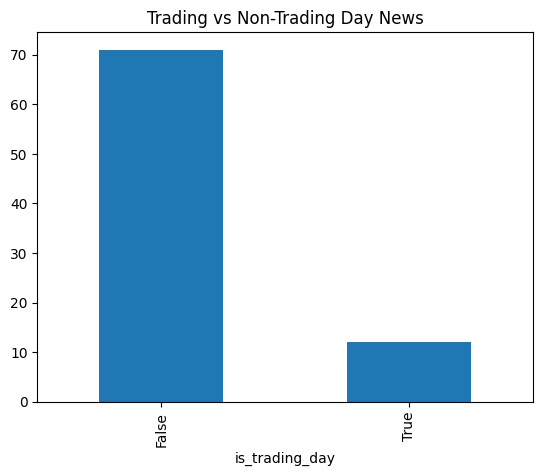

In [23]:
merged["is_trading_day"].value_counts().plot(kind="bar")
plt.title("Trading vs Non-Trading Day News")
plt.show()
